## Agentes de Utiliad: BDI Agent
- Estructura BDI (Creencias-Deseos-Intenciones)

### El núcleo del sistema sigue el modelo BDI:

#### Belief (Creencias):
- current_position: Posición actual del drone
- environment_map: Mapa del entorno (obstáculos, áreas libres y objetivo)
- q_table: Tabla Q que almacena el conocimiento aprendido
- Registro de recompensas y estados visitados

#### Desire (Deseos):
- primary: Objetivo principal (alcanzar el objetivo)
- secondary: Objetivos secundarios (evitar obstáculos, minimizar pasos)

#### Intention (Intenciones):
- current_plan: Secuencia de acciones planeadas
- learning_strategy: Estrategia de aprendizaje (Q-Learning)

### Proceso de Decisión
El agente sigue este flujo:

1. Percepción: Actualiza sus creencias con la posición actual y recompensas
-  Deliberación:
-  Usa ε-greedy para balancear exploración/explotación
-  Durante exploración (_explore), evita obstáculos inteligentemente
-  Durante explotación (_exploit), usa la Q-table para decisiones óptimas
-  Aprendizaje: Actualiza la Q-table usando la ecuación de Q-Learning

2. Mecanismo de Aprendizaje
- Q-Learning mejorado:
- Learning rate adaptativo (decrece con el tiempo)
- Decaimiento de ε para reducir exploración gradualmente
- Heurística de distancia para acelerar convergencia

3. Entrenamiento y Evaluación
- Entrena durante 2000 episodios
- Evalúa el rendimiento con 100 episodios de prueba
- Calcula métricas clave:
- Tasa de éxito
- Pasos promedio para alcanzar el objetivo
- Tiempo de ejecución
- Utilidad promedio

4. Visualización
- Muestra trayectorias óptimas en un gráfico 2D
- Destaca obstáculos, objetivo y camino recorrido
- Proporciona tablas con métricas de rendimiento

5. Flujo Principal
- El sistema ofrece un menú interactivo para:
- Ejecutar el agente BDI con Q-Learning
- Visualizar resultados
- Salir del sistema

6. Beneficios Clave
- Arquitectura modular que separa claramente conocimiento (BDI) de mecanismos de aprendizaje
- Toma de decisiones explicable: Podemos rastrear cómo las creencias afectan las decisiones
- Balance inteligente entre exploración y explotación
- Adaptabilidad mediante learning rate variable


###########################################################
### SISTEMA DE VALIDACIÓN DE ALGORITMOS PARA NAVEGACIÓN ###
###########################################################


Seleccione el algoritmo a validar:
1. Agente BDI con Q-Learning
2. Salir


Ingrese su elección (1-2):  1


Episodio 100, Recompensa promedio: 181.81, Epsilon: 0.1873
Episodio 200, Recompensa promedio: 186.87, Epsilon: 0.0723
Episodio 300, Recompensa promedio: 186.87, Epsilon: 0.0500
Episodio 400, Recompensa promedio: 186.87, Epsilon: 0.0500
Episodio 500, Recompensa promedio: 186.87, Epsilon: 0.0500
Episodio 600, Recompensa promedio: 186.87, Epsilon: 0.0500
Episodio 700, Recompensa promedio: 186.87, Epsilon: 0.0500
Episodio 800, Recompensa promedio: 186.87, Epsilon: 0.0500
Episodio 900, Recompensa promedio: 186.87, Epsilon: 0.0500
Episodio 1000, Recompensa promedio: 186.87, Epsilon: 0.0500
Episodio 1100, Recompensa promedio: 186.87, Epsilon: 0.0500
Episodio 1200, Recompensa promedio: 186.87, Epsilon: 0.0500
Episodio 1300, Recompensa promedio: 186.87, Epsilon: 0.0500
Episodio 1400, Recompensa promedio: 186.87, Epsilon: 0.0500
Episodio 1500, Recompensa promedio: 186.87, Epsilon: 0.0500
Episodio 1600, Recompensa promedio: 186.87, Epsilon: 0.0500
Episodio 1700, Recompensa promedio: 186.87, Epsil


¿Desea visualizar la trayectoria? (s/n):  s


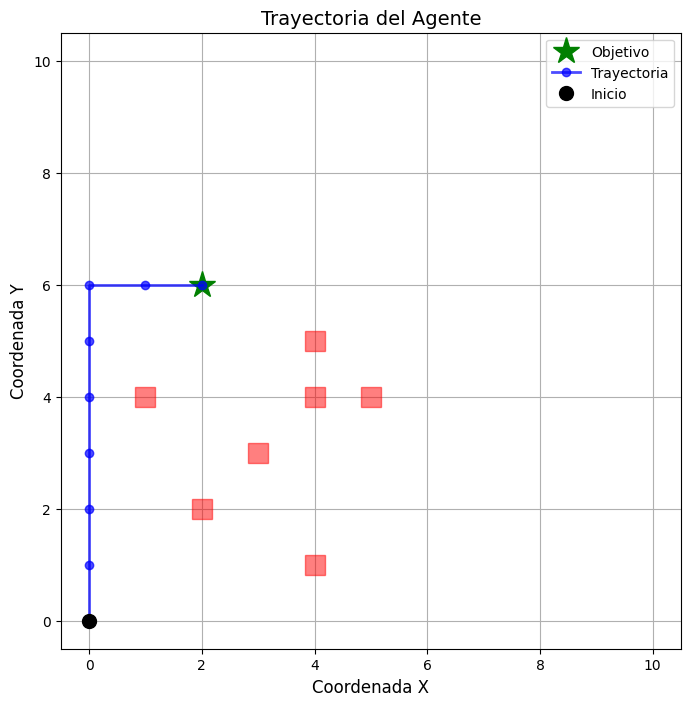


Seleccione el algoritmo a validar:
1. Agente BDI con Q-Learning
2. Salir


Ingrese su elección (1-2):  n


Opción no válida. Por favor intente nuevamente.

Seleccione el algoritmo a validar:
1. Agente BDI con Q-Learning
2. Salir


Ingrese su elección (1-2):  2


Saliendo del sistema...


In [17]:
import random
import numpy as np
import math
from collections import defaultdict
from dataclasses import dataclass, field
from typing import List, Tuple, Dict, Set
import time
from tabulate import tabulate
import matplotlib.pyplot as plt
from agent.alg_pomdp import UAVProblem
from agent.alg_pouct import run_pouct_experiment, run_pomcp_experiment
from agent.alg_qlearning import QLearningAgent, UAVEnvironment  # Vuelve a importar

## Componentes BDI
@dataclass
class Belief:
    """Representa el conocimiento del agente sobre el entorno"""
    current_position: Tuple[int, int]
    environment_map: Dict[Tuple[int, int], str]  # 'free', 'obstacle', 'target'
    q_table: Dict[Tuple[int, int], np.ndarray]
    last_reward: float = 0
    visited_states: Set[Tuple[int, int]] = field(default_factory=set)

@dataclass
class Desire:
    """Objetivos del agente"""
    primary: str = "reach_target"
    secondary: List[str] = field(default_factory=lambda: ["avoid_obstacles", "minimize_steps"])

@dataclass
class Intention:
    """Planes de acción del agente"""
    current_plan: List[str] = field(default_factory=list)
    learning_strategy: str = "q_learning"

class BDIAgent:
    def __init__(self, env, learning_rate=0.2, discount_factor=0.99,
                 exploration_rate=1.0, exploration_decay=0.999,
                 min_epsilon=0.05, adaptive_lr=True):
        self.env = env
        self.belief = Belief(
            current_position=env.reset(),
            environment_map=self._create_environment_map(),
            q_table=defaultdict(lambda: np.zeros(len(env.actions)))
        )
        self.desire = Desire()
        self.intention = Intention()
        
        # Parámetros de Q-Learning
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        self.epsilon_decay = exploration_decay
        self.min_epsilon = min_epsilon
        self.adaptive_lr = adaptive_lr
        self.episode_count = 0
        
    def _create_environment_map(self) -> Dict[Tuple[int, int], str]:
        """Construye un mapa del entorno basado en obstáculos y objetivo"""
        env_map = {}
        for x in range(self.env.width):
            for y in range(self.env.height):
                pos = (x, y)
                if pos in self.env.obstacles:
                    env_map[pos] = 'obstacle'
                elif pos == self.env.target:
                    env_map[pos] = 'target'
                else:
                    env_map[pos] = 'free'
        return env_map
    
    def update_beliefs(self, new_position: Tuple[int, int], reward: float):
        """Actualiza las creencias del agente"""
        self.belief.current_position = new_position
        self.belief.last_reward = reward
        self.belief.visited_states.add(new_position)
        
    def deliberate(self):
        """Toma decisiones basadas en creencias y deseos"""
        if self.belief.current_position == self.env.target:
            self.desire.primary = "target_reached"
            return "STOP"
        
        # Selección de acción ε-greedy
        if random.random() < self.epsilon:
            return self._explore()
        return self._exploit()
    
    def _explore(self) -> str:
        """Exploración inteligente que evita obstáculos"""
        valid_actions = []
        for action in self.env.actions:
            dx, dy = self.env.action_effects[action]
            new_state = (self.belief.current_position[0] + dx, 
                         self.belief.current_position[1] + dy)
            if self.env.is_valid_state(new_state):
                valid_actions.append(action)
        return random.choice(valid_actions) if valid_actions else random.choice(self.env.actions)
    
    def _exploit(self) -> str:
        """Explotación del conocimiento aprendido"""
        state = self.belief.current_position
        return self.env.actions[np.argmax(self.belief.q_table[state])]
    
    def update_q_table(self, state, action, reward, next_state):
        """Actualiza la Q-table usando el algoritmo Q-learning"""
        action_idx = self.env.actions.index(action)
        current_q = self.belief.q_table[state][action_idx]
        max_next_q = np.max(self.belief.q_table[next_state])
        
        # Learning rate adaptativo
        effective_lr = self.lr
        if self.adaptive_lr:
            effective_lr = self.lr / (1 + self.episode_count * 0.001)
            
        new_q = current_q + effective_lr * (reward + self.gamma * max_next_q - current_q)
        self.belief.q_table[state][action_idx] = new_q
        
        # Decaimiento de epsilon
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
    
    def train(self, episodes=2000, eval_interval=100):
        """Entrenamiento del agente"""
        rewards = []
        
        for episode in range(episodes):
            self.episode_count += 1
            state = self.env.reset()
            self.belief.current_position = state
            done = False
            episode_reward = 0
            
            while not done:
                action = self.deliberate()
                next_state, reward, done = self.env.step(state, action)
                
                self.update_beliefs(next_state, reward)
                self.update_q_table(state, action, reward, next_state)
                
                state = next_state
                episode_reward += reward
                
            rewards.append(episode_reward)
            
            if (episode + 1) % eval_interval == 0:
                avg_reward = np.mean(rewards[-eval_interval:])
                print(f"Episodio {episode+1}, Recompensa promedio: {avg_reward:.2f}, Epsilon: {self.epsilon:.4f}")

        return rewards
    
    def get_optimal_path(self, start_state):
        """Obtiene el camino óptimo usando conocimiento aprendido"""
        path = [start_state]
        state = start_state
        visited = set([state])
        
        for _ in range(self.env.width * self.env.height * 2):
            if state == self.env.target:
                break
                
            best_action = None
            best_value = -np.inf
            
            for action in self.env.actions:
                dx, dy = self.env.action_effects[action]
                new_state = (state[0] + dx, state[1] + dy)
                
                if not self.env.is_valid_state(new_state):
                    continue
                    
                action_idx = self.env.actions.index(action)
                q_value = self.belief.q_table[state][action_idx]
                
                # Heurística: favorecer movimientos que acerquen al objetivo
                dist = math.sqrt((new_state[0]-self.env.target[0])**2 + 
                               (new_state[1]-self.env.target[1])**2)
                heuristic = 1 / (1 + dist)
                total_value = q_value + 0.3 * heuristic
                
                if total_value > best_value and new_state not in visited:
                    best_value = total_value
                    best_action = action
                    
            if best_action is None:
                break
                
            dx, dy = self.env.action_effects[best_action]
            new_state = (state[0] + dx, state[1] + dy)
            path.append(new_state)
            visited.add(new_state)
            state = new_state
            
        return path


def display_metrics(metrics):
    headers = ["Métrica", "Valor"]
    table_data = [
        ["Tasa de Éxito", f"{metrics['success_rate']:.2%}"],
        ["Número Promedio de Pasos", f"{metrics['avg_steps']:.2f}"],
        ["Tiempo hasta Alcanzar Objetivo", f"{metrics['avg_time']:.2f} segundos"],
        ["Utilidad Promedio", f"{metrics['avg_utility']:.2f}"]
    ]
    print(tabulate(table_data, headers=headers, tablefmt="grid"))

def visualize_trajectory(trajectory, target, obstacles, size=(10,10)):
    plt.figure(figsize=(8, 8))
    
    # Dibujar obstáculos y objetivo
    for obs in obstacles:
        #plt.plot(obs[0], obs[1], 'rs', markersize=15, alpha=0.5, label='Obstáculos')
        plt.plot(obs[0], obs[1], 'rs', markersize=15, alpha=0.5)
    
    plt.plot(target[0], target[1], 'g*', markersize=20, label='Objetivo')
    
    # Dibujar trayectoria
    x, y = zip(*trajectory)
    plt.plot(x, y, 'b-o', alpha=0.7, linewidth=2, label='Trayectoria')
    plt.plot(x[0], y[0], 'ko', markersize=10, label='Inicio')
    
    plt.grid(True)
    plt.xlim(-0.5, size[0]+0.5)
    plt.ylim(-0.5, size[1]+0.5)
    plt.title("Trayectoria del Agente", fontsize=14)
    plt.xlabel("Coordenada X", fontsize=12)
    plt.ylabel("Coordenada Y", fontsize=12)
    plt.legend()
    plt.show()


## Integración con el sistema principal
def run_bdi_qlearning():
    env = UAVEnvironment(width=10, height=10, target=(2,6), 
                    obstacles=[(2,2), (3,3), (4,4), (1,4), (4,1), (4,5), (5,4), (6,1)])
    
    agent = BDIAgent(env, learning_rate=0.2, discount_factor=0.99,
                  exploration_rate=1.0, exploration_decay=0.999,
                  min_epsilon=0.05, adaptive_lr=True)
    
    start_time = time.time()
    rewards = agent.train(episodes=2000)
    
    # Evaluación
    success_count = 0
    total_steps = 0
    test_episodes = 100
    
    for _ in range(test_episodes):
        state = env.reset()
        agent.belief.current_position = state
        steps = 0
        done = False
        
        while not done and steps < 100:
            action = agent.deliberate()  # Usa el sistema BDI para decidir
            next_state, reward, done = env.step(state, action)
            agent.update_beliefs(next_state, reward)
            state = next_state
            steps += 1
        
        if done and state == env.target:
            success_count += 1
            total_steps += steps
    
    metrics = {
        'success_rate': success_count / test_episodes,
        'avg_steps': total_steps / success_count if success_count > 0 else 100,
        'avg_time': time.time() - start_time,
        'avg_utility': np.mean(rewards[-100:])
    }
    
    optimal_path = agent.get_optimal_path((0,0))
    return metrics, optimal_path

## Modificación de la función main para incluir la opción BDI
def main():
    print("###########################################################")
    print("### SISTEMA DE VALIDACIÓN DE ALGORITMOS PARA NAVEGACIÓN ###")
    print("###########################################################\n")
    
    while True:
        print("\nSeleccione el algoritmo a validar:")
        print("1. Agente BDI con Q-Learning")
        print("2. Salir")
        
        choice = input("Ingrese su elección (1-2): ")
        
        target = (2,6)
        obstacles = [(2,2), (3,3), (4,4), (1,4), (4,1), (4,5), (5,4)]
        
        if  choice == "1":
            metrics, trajectory = run_bdi_qlearning()
        elif choice == "2":
            print("Saliendo del sistema...")
            break
        else:
            print("Opción no válida. Por favor intente nuevamente.")
            continue
        
        print("\nResultados del algoritmo:")
        display_metrics(metrics)
        
        visualize = input("\n¿Desea visualizar la trayectoria? (s/n): ").lower()
        if visualize == 's':
            visualize_trajectory(trajectory, target, obstacles)

if __name__ == "__main__":
    main()